In [23]:
import pandas as pd
import geopandas as gpd

In [24]:
path = 'C:/Users/amira/OneDrive - University of Leeds/Projects/Palindrome/Market Segmentation/Data/DHS/Kenya/'
output_path = 'C:/Users/amira/OneDrive - University of Leeds/Projects/Palindrome/Market Segmentation/Code/Output Data/'

#### Sidenote: cell below brings rankings from old variable list to new variable list.

In [25]:
# # Import old variable List
# #DHS Variables (Cleaned) - Kieran.xlsx
# ahs_vars = pd.read_excel(output_path+'Variables/Excel/Old/Variables_ranked_old.xlsx', sheet_name=0)
# dhs_vars = pd.read_excel(output_path+'Variables/Excel/Old/Variables_ranked_old.xlsx', sheet_name=1)
# hiv_vars = pd.read_excel(output_path+'Variables/Excel/Old/Variables_ranked_old.xlsx', sheet_name=2)

# # Import new variable list
# ahs_vars_new = pd.read_excel(output_path+'Variables/Excel/Variables_processed.xlsx', sheet_name=0)
# dhs_vars_new = pd.read_excel(output_path+'Variables/Excel/Variables_processed.xlsx', sheet_name=1)
# hiv_vars_new = pd.read_excel(output_path+'Variables/Excel/Variables_processed.xlsx', sheet_name=2)

# # Bring rankings across from old list and save new file
# with pd.ExcelWriter(output_path+'Variables/Excel/Variables_ranked_auto.xlsx') as writer:
#     ahs_vars_new.merge(ahs_vars,how='left').to_excel(writer, sheet_name='AHS', index=False)
#     dhs_vars_new.merge(dhs_vars,how='left').to_excel(writer, sheet_name='DHS', index=False) #.drop(['variable','n_observations'], axis=1)
#     hiv_vars_new.merge(hiv_vars,how='left').to_excel(writer, sheet_name='HIV', index=False)

# Import raw datasets

In [26]:
### DHS
# Individuals (which is women)
dhs_w_raw = pd.read_stata(path+"KEIR72DT_Individual/KEIR72FL.DTA", convert_categoricals=True, order_categoricals=False)
# Men
dhs_m_raw = pd.read_stata(path+"KEMR72DT_Men/KEMR72FL.DTA", convert_categoricals=True, order_categoricals=False)

# No AHS or HIV test results for Kenya 2014

# Select variables
Same variables as SA for now. Drop all vars that do not exist in Kenya DHS.

### Ingest manual rankings for variables from excel file

In [27]:
# Import variables
# ahs_vars = pd.read_excel(output_path+'Variables/Excel/Variables_ranked (Manual).xlsx', sheet_name=0)
dhs_vars = pd.read_excel(output_path+'Variables/Excel/Variables_ranked (Manual).xlsx', sheet_name=1)
# hiv_vars = pd.read_excel(output_path+'Variables/Excel/Variables_ranked (Manual).xlsx', sheet_name=2)

In [28]:
# old - any selected (irrespective of ranking)
#condition = 'Demog.notna() | Context.notna() | Access.notna() | Willingness.notna() | Other.notna()'
# new - only ranked 1 variables
condition = 'Demog == 1 | Context == 1 | Access == 1 | Willingness == 1 | Other == 1'

# filter variables
# ahs_vars = ahs_vars.query(condition, engine="python")
dhs_vars = dhs_vars.query(condition, engine="python")
# hiv_vars = hiv_vars.query(condition, engine="python")

### Add on new chosen targets + sample weight variable
- NOTE: clean up this and previous section

In [29]:
new_target_vars = pd.read_excel(output_path+'Variables/SA/Variables_processed - New Targets.xlsx', sheet_name=3)
# get df corresponding to new targets
new_target_vars = new_target_vars[new_target_vars['new_targets'] == 1]
# new_target_vars

In [30]:
new_DHS_feature_vars = pd.read_csv(output_path+'Variables/SA/both_DHS_variables_men_and_women.csv')
# get df corresponding to new targets
new_DHS_feature_vars = new_DHS_feature_vars[new_DHS_feature_vars['new'] == 1]
# new_DHS_feature_vars

In [31]:
#### Note:
# old targets of HIV test and HI have a 0 in column
# interesting vars have a 2

# check if same variable has both sources
# new_all_vars[(new_all_vars['source_dhs']==1) & (new_all_vars['source_ahs']==1)]

# new_target_vars[new_target_vars['variable_men'].isnull()]
# new_target_vars.dropna(subset=['variable_men'])
# new_target_vars[new_target_vars['variable_women'].isnull()]
# # there are no "only for men" variables, but many "only for women" variables
# # so just rename

In [32]:
# add these onto the rest of the chosen variables
dhs_vars = dhs_vars.append(new_target_vars[new_target_vars["source_dhs"] == 1]).append(
    new_DHS_feature_vars.drop("ordered", axis=1)
)
# ahs_vars = ahs_vars.append(new_target_vars[new_target_vars["source_ahs"] == 1])

# drop possible duplicates (caused by the multiple variable selection processes)
dhs_vars = dhs_vars.drop_duplicates(subset=["variable_women", "variable_men"])

In [33]:
dhs_vars = dhs_vars.sort_index(ignore_index=True)

### Select variables from datasets

#### DHS

In [34]:
# Select chosen variables from raw datasets
## *Exclude those that are in SA but missing from Kenya

###### DHS
## Individuals (Women)
dhs_w_vars = dhs_vars['variable_women'].dropna()
# get which SA vars are missing from the Kenya dataset and remove those
missing_dhs_w_vars = [var for var in dhs_w_vars if var not in dhs_w_raw.columns]
dhs_w_vars = dhs_w_vars[~dhs_w_vars.isin(missing_dhs_w_vars)].tolist()
# select vars from raw dataset
dhs_w = dhs_w_raw[dhs_w_vars].copy()

## Men
dhs_m_vars = dhs_vars['variable_men'].dropna()
# get which SA vars are missing from the Kenya dataset and remove those
missing_dhs_m_vars = [var for var in dhs_m_vars.dropna() if var not in dhs_m_raw.columns]
dhs_m_vars = dhs_m_vars[~dhs_m_vars.isin(missing_dhs_m_vars)].tolist()
# select vars from raw dataset
dhs_m = dhs_m_raw[dhs_m_vars].copy()


print('women:', missing_dhs_w_vars)
print('men:', missing_dhs_m_vars)

women: ['v169a', 'v169b', 'v170', 'v171a', 'v171b', 'm69_1']
men: ['mv169a', 'mv169b', 'mv170', 'mv171a', 'mv171b']


In [35]:
# Relabel men's variables to match the women's
dhs_common = dhs_vars.dropna(subset=['variable_men','variable_women'])

In [36]:

dhs_men_to_women_var_rename_dict = dict(zip(dhs_common['variable_men'], dhs_common['variable_women']))
dhs_m.rename(dhs_men_to_women_var_rename_dict, axis=1, inplace=True)

# Merge datasets 
### (outer - preserve all rows)

In [37]:
# add gender columns to AHS and DHS surveys
# ahs_w['gender'] = 'woman'
# ahs_m['gender'] = 'man'

dhs_w['gender'] = 'woman'
dhs_m['gender'] = 'man'

# combine men and women for AHS and DHS
# ahs = pd.concat([ahs_w, ahs_m])
dhs = pd.concat([dhs_w, dhs_m])

In [38]:
# Add columns to signify data sources available for that row
###### REMOVE THIS SECTION IF DONE ALREADY
# ahs['source_ahs'] = 1
dhs['source_dhs'] = 1
# hiv['source_hiv'] = 1

In [39]:
# rename cluster, household, and line numbers
# DHS
dhs.rename(columns={'v001':'cluster','v002':'household','v003':'line'}, inplace = True)
# AHS
# ahs.rename(columns={'v001':'cluster','v002':'household','v003':'line'}, inplace = True)
# HIV
# hiv.rename(columns={'hivclust':'cluster','hivnumb':'household','hivline':'line'}, inplace = True)

In [40]:
df = dhs

# # combine DHS and AHS datasets
# new_cols_in_ahs = ahs.columns.difference(dhs.columns).tolist()
# ahs_cols_to_use = ['cluster','household','line'] + new_cols_in_ahs

# df = pd.merge(dhs, ahs[ahs_cols_to_use], on=['cluster','household','line'], how='outer') # outer keeps all rows from both datasets

# # add on HIV dataset
# df = pd.merge(df, hiv, on=['cluster','household','line'], how='outer')

In [41]:
'v021' in list(df.columns)

True

# Add geographical columns for spatial groupings

### Import GPS file (includes GPS coordinates for each housing cluster)

<AxesSubplot:>

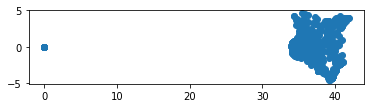

In [43]:
cluster_gps = gpd.read_file(path+'KEGE71FL_Geographic/KEGE71FL.dbf')
cluster_gps.plot()

In [44]:
# Useful columns from this dataframe
#cluster_gps.columns
#cluster_gps.iloc[0,:]

cluster_cols = [
    #'DHSID', 'DHSCC', 'DHSYEAR',                           # = ZA201700000001 to 750, ZA, 2017
    'DHSCLUST', 
    # 'CCFIPS',                                             # = SF  
    #'ADM1FIPS', 'ADM1FIPSNA', 'ADM1SALBNA', 'ADM1SALBCO',  # = NaN
    'ADM1DHS', 'ADM1NAME',
    #'DHSREGCO', 'DHSREGNA',                                # Repeats
    #'SOURCE',                                              # = GPS
    'URBAN_RURA',
    'LATNUM', 'LONGNUM',
    #'ALT_GPS', 'ALT_DEM', 'DATUM'                          # 9999, (ALT_DEM?), WGS84
    ]

### Import shapefiles for municipalities
https://data.humdata.org/dataset/south-africa-admin-level-1-boundaries 

<AxesSubplot:>

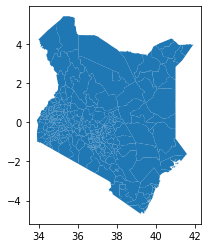

In [49]:
district_shapes_path = r'C:\Users\amira\OneDrive - University of Leeds\Projects\Palindrome\Market Segmentation\Data\UNOCHA KE Shapefiles\ken_adm_iebc_20191031_shp\\'
district_shapes = gpd.read_file(district_shapes_path+'ken_admbnda_adm2_iebc_20191031.dbf')
# change file to ken_admbnda_adm1_iebc_20191031.dbf for level-1 admin area

district_shapes.plot()

In [50]:
district_shapes.columns

Index(['Shape_Leng', 'Shape_Area', 'ADM2_EN', 'ADM2_PCODE', 'ADM2_REF',
       'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN',
       'ADM0_PCODE', 'date', 'validOn', 'ValidTo', 'geometry'],
      dtype='object')

In [54]:
# Useful columns from this dataframe
# district_shapes.columns
district_cols = [
    # Municipality
    # 'ADM3_ID', 'ADM3_EN', 'ADM3_PCODE', 
    #'ADM3_REF', 'ADM3ALT1EN', 'ADM3ALT2EN', # = NaN
    # District
    # 'ADM2_ID', 
    'ADM2_EN', 'ADM2_PCODE', 
    # Region
    # 'ADM1_ID', 
    'ADM1_EN', 'ADM1_PCODE',
    # Country
    # 'ADM0_EN', 'ADM0_PCODE', 
    # Date information
    # 'date', 'validOn', 'validTo'
    ]

# date: 2018-12-27
# validOn: 2020-11-09
# validTo: NaN
# Based on data from 2016.

### Find out which municipality each cluster is within
(Double check the integrity of such grouping - I think errors only valid to level-2 adminstrative areas, not 3)

In [55]:
# ensure they are using the same projection
district_shapes.crs = cluster_gps.crs
# join dataframes
enhanced_gps_geopandas = gpd.sjoin(district_shapes, cluster_gps, how="right")

In [58]:
# convert to regular dataframe
enhanced_gps_df = pd.DataFrame(enhanced_gps_geopandas)

# discard unwanted columns
gps_cols_to_keep =  cluster_cols + district_cols
enhanced_gps_df = enhanced_gps_df[gps_cols_to_keep]

# convert cluster and region numbers to integers from floats
enhanced_gps_df['DHSCLUST'] = enhanced_gps_df['DHSCLUST'].astype('int')
enhanced_gps_df['ADM1DHS'] = enhanced_gps_df['ADM1DHS'].astype('int')

# rename cluster column to prepare for merging into main DHS dataframe
enhanced_gps_df.rename(columns={'DHSCLUST':'cluster'}, inplace=True)

enhanced_gps_df.head()

cluster  ADM1DHS ADM1NAME URBAN_RURA    LATNUM    LONGNUM    ADM2_EN  \
0        1       90  Nairobi          U -1.282723  36.752958   Kilimani   
1        2       90  Nairobi          U -1.278781  36.758441   Kilimani   
2        3       90  Nairobi          U -1.279646  36.745931   Kilimani   
3        4       90  Nairobi          U -1.280380  36.697090  Dagoretti   
4        5       90  Nairobi          U -1.272064  36.743127  Westlands   

  ADM2_PCODE  ADM1_EN ADM1_PCODE  
0   KE047275  Nairobi      KE047  
1   KE047275  Nairobi      KE047  
2   KE047275  Nairobi      KE047  
3   KE047276  Nairobi      KE047  
4   KE047274  Nairobi      KE047

### Finally, add municipality column to the main merged DHS dataset

In [59]:
df = df.merge(enhanced_gps_df)

# Resulting data:

In [60]:
# save merged dataframe to file
df.to_csv(output_path+'DHS_Kenya_merged.csv', index=False)

In [61]:
print('Observations with DHS data:', df.query('source_dhs == 1').shape[0])

Observations with DHS data: 43898


In [22]:
# print('Observations with DHS data:', df.query('source_dhs == 1').shape[0])
# print('Observations with AHS data:', df.query('source_ahs == 1').shape[0])
# print('Observations with DHS and AHS data:', df.query('source_dhs == 1 and source_ahs == 1').shape[0])
# print('Observations with DHS and AHS and HIV data:', df.query('source_dhs == 1 and source_ahs == 1 and source_hiv == 1').shape[0])

# ## OLD
# # Observations with DHS data: 12132
# # Observations with AHS data: 10336
# # Observations with DHS and AHS data: 7811
# # Observations with DHS and AHS and HIV data: 4862